![self_rag](https://github.com/realyinchen/RAG/blob/main/imgs/self_rag.png?raw=true)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_BASE = os.environ.get("OPENAI_API_BASE")
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

LANGCHAIN_TRACING_V2 = os.environ.get("LANGCHAIN_TRACING_V2")
LANGCHAIN_ENDPOINT = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.environ.get("LANGCHAIN_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

llm = ChatOpenAI(model="qwen-max", temperature=0)

model_name = "C:\\Home\\Documents\\Projects\\models\\BAAI\\bge-large-en-v1.5"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
embedding_model = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

c:\Apps\miniconda3\envs\rag\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Vector Store

In [3]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

client = QdrantClient(host="localhost", port=6333)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="agentic_rag",
    embedding=embedding_model,
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

# Retrieval Grader

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [6]:
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


# Generate

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "context"],
)

rag_chain = prompt | llm | StrOutputParser()

In [8]:
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In a LLM-powered autonomous agent system, the agent's memory is divided into short-term and long-term. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval.


# Hallucination Grader

In [9]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

In [10]:
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

# Answer Grader

In [11]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [12]:
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

# Question Re-writer

In [13]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [14]:
question_rewriter.invoke({"question": question})

'What are the key aspects and mechanisms of agent memory in artificial intelligence?'

# Construct the Graph

### Define Graph State

In [15]:
from typing import List, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of document
        steps: list of step
    """

    question: str
    generation: str
    documents: List[str]
    steps: List[str]

### Define Nodes

In [16]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    steps = state["steps"]
    steps.append("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    steps = state["steps"]
    steps.append("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    steps = state["steps"]
    steps.append("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            steps.append("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            steps.append("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    steps = state["steps"]
    steps.append("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

# Define Edges

In [17]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    steps = state["steps"]
    steps.append("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        steps.append("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        steps.append("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    steps = state["steps"]
    steps.append("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        steps.append("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        steps.append("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            steps.append("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            steps.append("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        steps.append("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

# Build Graph

In [18]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

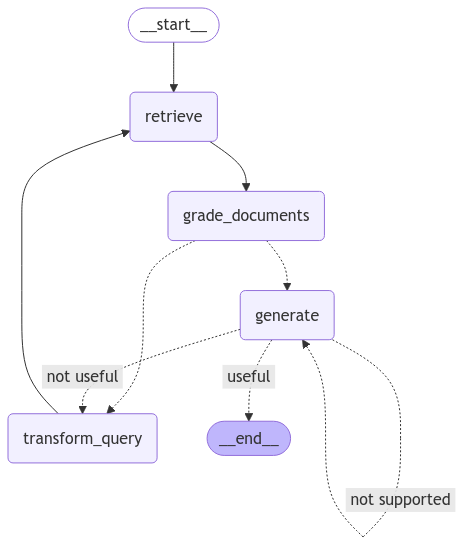

In [19]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Use Graph

In [20]:
import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    state_dict = app.invoke(
        {"question": example["input"], "steps": []}, config
    )
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

In [21]:
example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'The types of agent memory include short-term memory, which is used for in-context learning, and long-term memory, which allows the agent to retain and recall information over extended periods, often using an external vector store.',
 'steps': ['---RETRIEVE---',
  '---CHECK DOCUMENT RELEVANCE TO QUESTION---',
  '---GRADE: DOCUMENT NOT RELEVANT---',
  '---GRADE: DOCUMENT RELEVANT---',
  '---GRADE: DOCUMENT RELEVANT---',
  '---ASSESS GRADED DOCUMENTS---',
  '---DECISION: GENERATE---',
  '---GENERATE---',
  '---CHECK HALLUCINATIONS---',
  '---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---',
  '---GRADE GENERATION vs QUESTION---',
  '---DECISION: GENERATION ADDRESSES QUESTION---']}